<a href="https://colab.research.google.com/github/ElZho/Translate-from-old-russian-language.Seq2seq-model./blob/main/Translation_with_BPE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install youtokentome

     |████████████████████████████████| 1.7 MB 2.1 MB/s 


In [1]:
import pandas as pd
import numpy as np

In [4]:
import youtokentome as yttm

In [5]:
import random

In [6]:
import unicodedata
import string
import re
import itertools

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import tqdm
from tqdm import tqdm

In [8]:
import time
import math
from collections import defaultdict

In [9]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [10]:
from google.colab import drive
drive.mount('/content/drive')
!cp -r ./drive/My\ Drive/NLP_translation/* .

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
from model import EncoderRNN, AttnDecoderRNN, TONModel

Change path to dataset if it needed

In [10]:
config = {  
    #'path'  :'./old_slav.txt', #old slavenic - rus
    'path':'./rus.txt', #rus-eng
    'MAX_LENGTH':40,
    'reverse':True,
    'pad_index':[0,1],
    
    'batch_size':256, # for short datasets use batch_size - 8, for big dataset - 256

    'teacher_forcing_ratio': 0.5,
    'hidden_size':512,
    'num_epochs':25,
    
    'lr': 0.001
}

In [24]:
from preprocessing_bpe import prepareData, readLangs, tensorsFromPair, tensorFromSentence

Bilding a BPE model is in preprocessing_bpe. There is BPE models are created for source and target. Models are saved in working directory. It can by load using `bpe = yttm.BPE(model=model_path)` 
Length of vocabulary is 200 and sets in prepareData. 

In [12]:
#eng-rus
train_pairs, tokenazer_train_src, tokenazer_train_trg, test_pairs,\
   tokenazer_test_src, tokenazer_test_trg = prepareData('eng', 'rus', config['path'], config['MAX_LENGTH'], config['reverse'])
print(random.choice(train_pairs))

Reading lines...
Read 308153 sentence pairs train
Read 132066 sentence pairs test
Trimmed to 308151 sentence train pairs
Trimmed to 132064 sentence test pairs
Counting words...


100%|██████████| 132064/132064 [00:00<00:00, 1216495.36it/s]


["tom doesn't know anything about fishing", 'том ничего не знает о рыбалке', 'cc-by 20 (france) attribution: tatoebaorg #7541991 (ck) & #8283144 (fjay69)']


Check tokenazer work

In [ ]:
tokenazer_train_trg.decode(tokenazer_train_trg.encode(train_pairs[435][1].split(' ')))

['я', 'мало', 'что', 'понимаю', 'в', 'рыбалке']

In [ ]:
tokenazer_train_trg.encode(train_pairs[435][1].split(' '))

[[107],
 [103, 113, 5],
 [122],
 [106, 146, 164, 30],
 [100],
 [4, 15, 22, 23, 113, 19, 6]]

In [22]:
tokenazer_train_trg.decode([107, 103, 113, 5, 122,106, 146, 164, 30, 100, 4,15, 22, 23, 113, 19, 6, 0])

['я мало что понимаю в рыбалке<PAD>']

Check length of tokenied sentences

In [18]:
#max length of train sentence old slav - rus
len_train=([len(tokenazer_train_src.encode(pair[0])), len(tokenazer_train_trg.encode(pair[1]))] for pair in train_pairs)
max(len_train)#max length of train sentence

[68, 79]

In [19]:
#max length of test sentence old slav - rus
len_test=([len(tokenazer_test_src.encode(pair[0])), len(tokenazer_test_trg.encode(pair[1]))] for pair in test_pairs)
max(len_test)#max length of train sentence

[66, 71]

In [14]:
#max length of train sentence rus-eng
len_train=([len(tokenazer_train_src.encode(pair[0])), len(tokenazer_train_trg.encode(pair[1]))] for pair in train_pairs)
max(len_train)#max length of train sentence

[126, 78]

In [15]:
#max length of test sentence rus-eng
len_test=([len(tokenazer_test_src.encode(pair[0])), len(tokenazer_test_trg.encode(pair[1]))] for pair in test_pairs)
max(len_test)#max length of train sentence

[98, 62]

In [13]:
def len_pair(pair):
  len_0=len(tokenazer_train_src.encode(pair[0]))
  len_1=len(tokenazer_train_trg.encode(pair[1]))
  return len_0, len_1
len_train_old=[] 
len_train_new=[] 
for pair in train_pairs:  
  old, new=len_pair(pair)
  len_train_old.append(old)
  len_train_new.append(new)

Plot length of sentences distribution

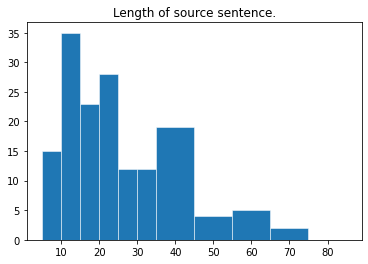

In [ ]:
#max length of train sentence old slav - rus
fig, ax = plt.subplots()
ax.hist(len_train_old, bins=[5, 10, 15, 20, 25, 30, 35, 45, 55, 65, 75, 85], linewidth=0.5, edgecolor="white")
plt.title('Length of source sentence.');

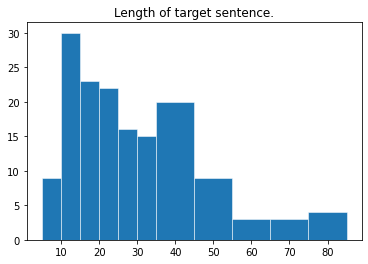

In [ ]:
#max length of train sentence old slav - rus
fig, ax = plt.subplots()
ax.hist(len_train_new, bins=[5, 10, 15, 20, 25, 30, 35, 45, 55, 65, 75, 85], linewidth=0.5, edgecolor="white")
plt.title('Length of target sentence.');

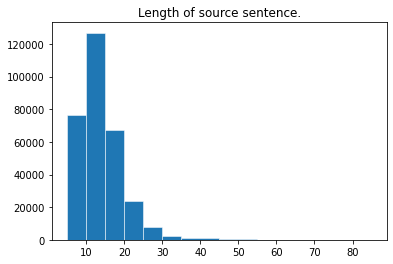

In [16]:
#max length of train sentence rus-eng
fig, ax = plt.subplots()
ax.hist(len_train_old, bins=[5, 10, 15, 20, 25, 30, 35, 45, 55, 65, 75, 85], linewidth=0.5, edgecolor="white")
plt.title('Length of source sentence.');

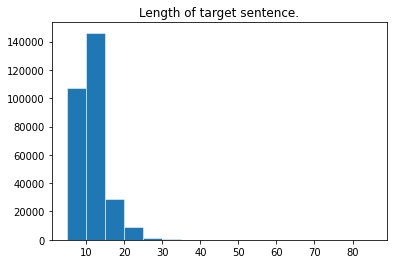

In [17]:
#max length of train sentence rus-eng
fig, ax = plt.subplots()
ax.hist(len_train_new, bins=[5, 10, 15, 20, 25, 30, 35, 45, 55, 65, 75, 85], linewidth=0.5, edgecolor="white")
plt.title('Length of target sentence.');

Create train and test dataloaders

In [19]:
training_pairs = [tensorsFromPair(train_pair, tokenazer_train_src, tokenazer_train_trg, MAX_LENGTH=config['MAX_LENGTH'])
                      for train_pair in tqdm(train_pairs)]
testing_pairs = [tensorsFromPair(test_pair, tokenazer_test_src, tokenazer_test_trg, MAX_LENGTH=config['MAX_LENGTH'])
                      for test_pair in tqdm(test_pairs)]
train_loader = torch.utils.data.DataLoader(training_pairs, batch_size=config['batch_size'], shuffle=True)
test_loader = torch.utils.data.DataLoader(testing_pairs, batch_size=config['batch_size'], shuffle=False)

100%|██████████| 132064/132064 [00:10<00:00, 12514.38it/s]


Make helper functions.

In [13]:
#function to check time
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [14]:
#function to plot loss curves
def plot_learning_curves(history):
    sns.set_style(style='whitegrid')
    fig = plt.figure(figsize=(10,5))

    # plt.subplot(1,3,1)
    plt.title('Loss', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.xlabel('epoch', fontsize=15)
    plt.legend()
    plt.show()

Create a traning model using dataloader.
Made changes: 
1. epoch iteration. Each epoch is train on all train dataset and validate on test dataset.
2. Encoder and decoder comunication is in model. In training model function I just pass input tensor, output tensor and input sentence length into model and get decoder output out.
3. I use batches to load data, so outputs and target have to be transformed to pass to loss function.
4. I collect train and validation loss for each epoch into defaultdict.
5. I plot train and validation loss after the training.
6. I save best model during the training.

In [15]:
#model with data loader
def train_modelIters(model, optimizer, loader, test_loader, criterion, num_epochs=6, scheduler=None):
    start = time.time() #start time
    itog_losses = []
    best_loss=np.inf #initiate best loss to check and save model with best loss.

    history = defaultdict(lambda: defaultdict(list))  #dictionry to collect losses  
      
    for epoch in tqdm(range(num_epochs), desc='epochs'):
      model.train(True)      

      plot_losses = []
      #print_loss_total = 0  
      plot_loss_total = 0

      val_losses = []
      val_loss_total = 0  
      
      #train loop
      for batch in tqdm(loader, desc='train sample batches'):
          
          input_tensor = batch[0].to(device)
          input_len=batch[1]          #true length  of sentences in batches withput padding
          target_tensor = batch[2].to(device)                           
         
          decoder_outputs, _ = model(input_tensor, input_len, target_tensor)
          
          target_tensor = target_tensor.view(-1) #change dimantion in one size
          output_dim = decoder_outputs.shape[-1]  #change dimantion in one size
          decoder_outputs=decoder_outputs.view(-1, output_dim)  #change dimantion in one size
          
          loss = criterion(decoder_outputs, target_tensor)      #calculate loss
          
          loss.backward(retain_graph=True)    
          optimizer.step()
          optimizer.zero_grad()                   
          
          plot_loss_total += loss.item() #collect losses
          
      plot_loss_avg = plot_loss_total /  len(loader)
      history['loss']['train'].append(plot_loss_avg)
      
      model.train(False)
      #validation loop
      for batch in tqdm(test_loader, desc='validation sample batches'):
        
        input_tensor = batch[0].to(device)
        input_len=batch[1]
        target_tensor = batch[2].to(device)
               
        with torch.no_grad():
          decoder_outputs, _ = model(input_tensor, input_len, target_tensor,
                                  evalute=True)
          
          target_tensor = target_tensor.view(-1)
          output_dim = decoder_outputs.shape[-1]            
          decoder_outputs=decoder_outputs.view(-1, output_dim)    
          
          val_loss = criterion(decoder_outputs, target_tensor) # calculate validation loss          
          val_loss_total+= loss.item() #collect loss item
          if scheduler!=None:
            scheduler.step(val_loss)

      val_loss_avg = val_loss_total / len(test_loader)    
      history['loss']['val'].append(val_loss_avg)
      print('Epoch train loss', plot_loss_avg, end='\n')
      print('Epoch val_loss', val_loss_avg, end='\n')

      if val_loss_avg<best_loss: #save best model
        best_loss=val_loss
        torch.save(model, '/content/drive/MyDrive/NLP_translation/best_model_eng.pt')

    plot_learning_curves(history) #plot loss curves
    return 

Train model using Adam optimizer, NLLLos and scheduler

train sample batches: 100%|██████████| 1204/1204 [08:29<00:00,  2.36it/s]

epochs:   4%|▍         | 1/25 [09:50<3:56:18, 590.77s/it]

Epoch train loss 3.850028146541
Epoch val_loss 3.7432820796966553



train sample batches: 100%|██████████| 1204/1204 [08:34<00:00,  2.34it/s]

epochs:   8%|▊         | 2/25 [19:47<3:47:47, 594.25s/it]

Epoch train loss 3.6401196227121195
Epoch val_loss 3.61745548248291



train sample batches: 100%|██████████| 1204/1204 [08:35<00:00,  2.34it/s]

epochs:  12%|█▏        | 3/25 [29:44<3:38:19, 595.43s/it]

Epoch train loss 3.5676436598514796
Epoch val_loss 3.611119508743286



train sample batches: 100%|██████████| 1204/1204 [08:35<00:00,  2.34it/s]

epochs:  16%|█▌        | 4/25 [39:41<3:28:39, 596.16s/it]

Epoch train loss 3.521299345548763
Epoch val_loss 3.493492603302002



train sample batches: 100%|██████████| 1204/1204 [08:35<00:00,  2.33it/s]

epochs:  20%|██        | 5/25 [49:39<3:18:54, 596.70s/it]

Epoch train loss 3.4859390290472594
Epoch val_loss 3.605888605117798



train sample batches: 100%|██████████| 1204/1204 [08:35<00:00,  2.33it/s]

epochs:  24%|██▍       | 6/25 [59:37<3:09:06, 597.18s/it]

Epoch train loss 3.4581289881487622
Epoch val_loss 3.4997568130493164



train sample batches: 100%|██████████| 1204/1204 [08:35<00:00,  2.33it/s]

epochs:  28%|██▊       | 7/25 [1:09:35<2:59:13, 597.43s/it]

Epoch train loss 3.436362707931734
Epoch val_loss 3.425401449203491



train sample batches: 100%|██████████| 1204/1204 [08:35<00:00,  2.33it/s]

epochs:  32%|███▏      | 8/25 [1:19:33<2:49:18, 597.57s/it]

Epoch train loss 3.4166944933888126
Epoch val_loss 3.403435468673706



train sample batches: 100%|██████████| 1204/1204 [08:35<00:00,  2.33it/s]

epochs:  36%|███▌      | 9/25 [1:29:30<2:39:22, 597.64s/it]

Epoch train loss 3.4002203258169055
Epoch val_loss 3.4256832599639893



train sample batches: 100%|██████████| 1204/1204 [08:36<00:00,  2.33it/s]

epochs:  40%|████      | 10/25 [1:39:29<2:29:28, 597.88s/it]

Epoch train loss 3.3854265971437245
Epoch val_loss 3.380647897720337



train sample batches: 100%|██████████| 1204/1204 [08:35<00:00,  2.33it/s]

epochs:  44%|████▍     | 11/25 [1:49:27<2:19:30, 597.92s/it]

Epoch train loss 3.373384500460767
Epoch val_loss 3.2846271991729736



train sample batches: 100%|██████████| 1204/1204 [08:36<00:00,  2.33it/s]

epochs:  48%|████▊     | 12/25 [1:59:25<2:09:35, 598.08s/it]

Epoch train loss 3.3627406051784656
Epoch val_loss 3.424614191055298



train sample batches: 100%|██████████| 1204/1204 [08:36<00:00,  2.33it/s]

epochs:  52%|█████▏    | 13/25 [2:09:24<1:59:38, 598.19s/it]

Epoch train loss 3.352141276348469
Epoch val_loss 3.3583786487579346



train sample batches: 100%|██████████| 1204/1204 [08:35<00:00,  2.33it/s]

epochs:  56%|█████▌    | 14/25 [2:19:22<1:49:39, 598.14s/it]

Epoch train loss 3.3429329989360417
Epoch val_loss 3.431175470352173



train sample batches: 100%|██████████| 1204/1204 [08:35<00:00,  2.33it/s]

epochs:  60%|██████    | 15/25 [2:29:20<1:39:40, 598.05s/it]

Epoch train loss 3.335108351469832
Epoch val_loss 3.4011123180389404



train sample batches: 100%|██████████| 1204/1204 [08:35<00:00,  2.34it/s]

epochs:  64%|██████▍   | 16/25 [2:39:17<1:29:41, 597.94s/it]

Epoch train loss 3.3267496851987617
Epoch val_loss 3.386376142501831



train sample batches: 100%|██████████| 1204/1204 [08:35<00:00,  2.34it/s]

epochs:  68%|██████▊   | 17/25 [2:49:15<1:19:42, 597.86s/it]

Epoch train loss 3.3192785229793813
Epoch val_loss 3.2284786701202393



train sample batches: 100%|██████████| 1204/1204 [08:34<00:00,  2.34it/s]

epochs:  72%|███████▏  | 18/25 [2:59:12<1:09:43, 597.66s/it]

Epoch train loss 3.3130906515343246
Epoch val_loss 3.3524346351623535



train sample batches: 100%|██████████| 1204/1204 [08:34<00:00,  2.34it/s]

epochs:  76%|███████▌  | 19/25 [3:09:09<59:44, 597.45s/it]  

Epoch train loss 3.307489288605725
Epoch val_loss 3.2433173656463623



train sample batches: 100%|██████████| 1204/1204 [08:34<00:00,  2.34it/s]

epochs:  80%|████████  | 20/25 [3:19:06<49:46, 597.30s/it]

Epoch train loss 3.301624909389851
Epoch val_loss 3.2861082553863525



train sample batches: 100%|██████████| 1204/1204 [08:33<00:00,  2.35it/s]

epochs:  84%|████████▍ | 21/25 [3:29:02<39:47, 596.80s/it]

Epoch train loss 3.2969507656224146
Epoch val_loss 3.2952113151550293



train sample batches: 100%|██████████| 1204/1204 [08:34<00:00,  2.34it/s]

epochs:  88%|████████▊ | 22/25 [3:38:59<29:50, 596.84s/it]

Epoch train loss 3.2914054764069594
Epoch val_loss 3.343127489089966



train sample batches: 100%|██████████| 1204/1204 [08:33<00:00,  2.35it/s]

epochs:  92%|█████████▏| 23/25 [3:48:55<19:53, 596.56s/it]

Epoch train loss 3.2875831703410987
Epoch val_loss 3.277676582336426



train sample batches: 100%|██████████| 1204/1204 [08:34<00:00,  2.34it/s]

epochs:  96%|█████████▌| 24/25 [3:58:52<09:56, 596.69s/it]

Epoch train loss 3.2838926166791063
Epoch val_loss 3.2565808296203613



train sample batches: 100%|██████████| 1204/1204 [08:33<00:00,  2.34it/s]

epochs: 100%|██████████| 25/25 [4:08:48<00:00, 597.14s/it]


Epoch train loss 3.2810403189785853
Epoch val_loss 3.340533494949341


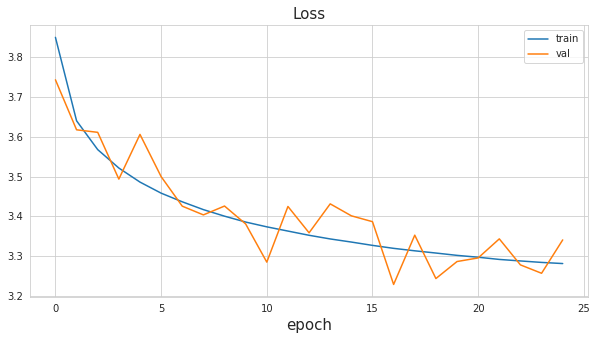

In [ ]:
#model with batches eng-rus

encoder1 = EncoderRNN(200, config['hidden_size'])
attn_decoder1 = AttnDecoderRNN(config['hidden_size'], 200, config['MAX_LENGTH'], dropout_p=0.1)
model=TONModel(encoder1, attn_decoder1, config['teacher_forcing_ratio']).to(device)

optimizer = optim.Adam(model.parameters(), lr=config['lr'])
criterion = nn.NLLLoss(ignore_index=0)

train_modelIters(model, optimizer, train_loader, test_loader, criterion, config['num_epochs'])

Results are worser then without BPE tokenier. Lets check bleu score.

In [27]:
import gc

gc.collect()

3064

In [16]:
from nltk.translate.bleu_score import sentence_bleu

In [17]:
from nltk.translate.bleu_score import SmoothingFunction

In [18]:
from sklearn.metrics import precision_score

Create helper function to calculite bleu score using word vectors.

In [19]:
def bleu_score(predict, target):
  # predict=predict.tolist()
  # if 0 in  predict:
  #   m=predict.index(0)
  #   predict=predict[:m]
  p=len(predict)
  t=len(target)
  k=t-p  
  if k>0:
    predict.extend(itertools.repeat(0, abs(k)))
  elif k<0 : 
    target.extend(itertools.repeat(0, abs(k)))
  if min(p, t)<2:    
    bleu_itog=precision_score(target, predict, average='micro',zero_division=0)
  else:
    n=min(p, t, 4)  
  bleu=np.zeros(n)
  bleu[0]=precision_score(target, predict, average='micro', zero_division=0)
  for i in range(2, n+1):
    y_pred=[predict[idx:idx+i] for idx in range(n-i+1)]
    y_true=[target[idx:idx+i] for idx in range(n-i+1)]
    bleu[i-1]=np.mean([precision_score(y_true[idx], y_pred[idx], average='micro', zero_division=0) for idx in range(n-i+1)])
    #bleu[i-1]=precision_score(y_true, y_pred, average='micro', zero_division=0)
  bleu_itog= bleu.mean() 
  return  bleu_itog 

Create helper function to randomly translate sentences.

In [20]:
def evaluateRandomly(model, pairs, tokenazer_src, tokenazer_trg, n=10):
    for i in range(n):
        outputs=[]
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        
        input_tensor = tensorFromSentence(tokenazer_src, pair[0], config['MAX_LENGTH'])
        input_len=torch.tensor([len(pair[0].split(' '))], dtype=torch.int64)
        target_tensor=tensorFromSentence(tokenazer_trg, pair[1], config['MAX_LENGTH'])
                
        output_words, _ = model(input_tensor.reshape(1,config['MAX_LENGTH']), input_len, target_tensor.reshape(1,config['MAX_LENGTH']), evalute=True)    
        
        result=output_words.argmax(2).detach()
        result=result.squeeze(0)
        result=result.tolist()
        if 0 in  result:
          m=result.index(0)
          result=result[:m]
         
        outputs=tokenazer_trg.decode(result)              
        output_sentence = ' '.join(outputs)
        print('<', output_sentence)
        print('')
        
        print('Blue score of this sentence  - ', sentence_bleu(outputs, pair[1].split(' '), smoothing_function=SmoothingFunction().method1))
        print('')
        print('Blue score of this sentence my function - ', bleu_score(result, tokenazer_trg.encode(pair[1])))
        print('')
        print('======================================')

Create function to plot attention.

In [28]:
def evaluate(model, pairs, tokenazer_src=tokenazer_train_src, tokenazer_trg=tokenazer_train_trg):
    outputs=[]        
    input_tensor = tensorFromSentence(tokenazer_src, pairs[0], config['MAX_LENGTH'])
    input_len=torch.tensor([len(pairs[0].split(' '))], dtype=torch.int64)
    target_tensor=tensorFromSentence(tokenazer_trg, pairs[1], config['MAX_LENGTH'])
                
    output_words, attention = model(input_tensor.reshape(1,config['MAX_LENGTH']), input_len, target_tensor.reshape(1,config['MAX_LENGTH']), evalute=True)    
        
    result=output_words.argmax(2).detach()
    result=result.squeeze(0)
    result=result.tolist()
    if 0 in  result:
          m=result.index(0)
          result=result[:m]        
     
    outputs=tokenazer_trg.decode(result)       
    return    outputs,  attention

In [34]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze().cpu().detach()
    attention=attention.tolist()
    if 0 in  attention:
          m=attention.index(0)
          attention=attention[:m]
    a=torch.zeros(len(attention), len(attention))
    print(attention)
    for idx in range(len(attention)):
      a[idx,idx]=attention[idx]
    cax = ax.matshow(a.numpy(), cmap='bone')
   
    ax.tick_params(labelsize=15)
    
    x_ticks = [''] + [t.lower() for t in sentence]
    y_ticks = [''] + [t for t in translation[0].split(' ')]
    
    ax.set_xticklabels(x_ticks, rotation=90)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

def evaluateAndShowAttention(input_sentence, model=model):
    output_words, attentions = evaluate(model, input_sentence)
    print('input =', input_sentence[0])
    print('output =', ' '.join(output_words))
    attentions=attentions.detach()
    
    display_attention(input_sentence[0].split(' '), output_words, attentions)

Check randomly translation

In [141]:
#40 epochs hidden 512 BPE
evaluateRandomly(model, train_pairs, tokenazer_train_src, tokenazer_train_trg)

> are you sure there's no solution
= ты уверена что решения не существует
< ты уверен чтотутутутутутутутутутутутутутутутуту

Blue score of this sentence  -  0

Blue score of this sentence my function -  0.7875

> he carried a cane
= он нес трость
< он нессссссссссссссссссссссссссссссссссссс

Blue score of this sentence  -  0

Blue score of this sentence my function -  0.78125

> were you able to sleep at all
= ты вообще смог поспать
< вы в помог помог помог помог помог помог помог помог помог помог помог помог помо

Blue score of this sentence  -  0

Blue score of this sentence my function -  0.23541666666666666

> the weather changed quickly
= погода быстро менялась
< погода былаядагояя

Blue score of this sentence  -  0

Blue score of this sentence my function -  0.85

> the children chanted "rain rain go away come again another day"
= дети запели: «дождик дождик прекрати в другои день ты приходи»
< етииииииириииииииииииижииииенетииииетиииетии

Blue score of this sentence  -  0

Blue

In [142]:
#40 epochs hidden 512 BPE
evaluateRandomly(model, test_pairs, tokenazer_test_src, tokenazer_test_trg)

> i don't know how you do it
= я не знаю как вы это делаете
< ебетаууууууууууууууууууууууууууууууууууууу

Blue score of this sentence  -  0

Blue score of this sentence my function -  0.0

> did you report that to the police
= вы сообщили об этом полиции
< етссссссссссссссссссссссссссссссссссссссс

Blue score of this sentence  -  0

Blue score of this sentence my function -  0.0

> it's crowded today
= сегодня полно народа
< ноуу рауууиу мэритуу

Blue score of this sentence  -  0

Blue score of this sentence my function -  0.0

> we found the boy fast asleep
= мы обнаружили мальчика крепко спящим
< гохоикохоихохокохоиихокоахоихоаихоиекохо

Blue score of this sentence  -  0

Blue score of this sentence my function -  0.0

> i'd like to get to know you better
= я хотел бы узнать тебя получше
< ать к к к к к к к к к к к к к к к к

Blue score of this sentence  -  0

Blue score of this sentence my function -  0.0

> you'd better give up
= вам лучше сдаться
< ру к к к к к к к к к к к к к к к

Plot attention

input = tom lost the money i gave him 
output = том потерял деньги  которые я ему дал  которые


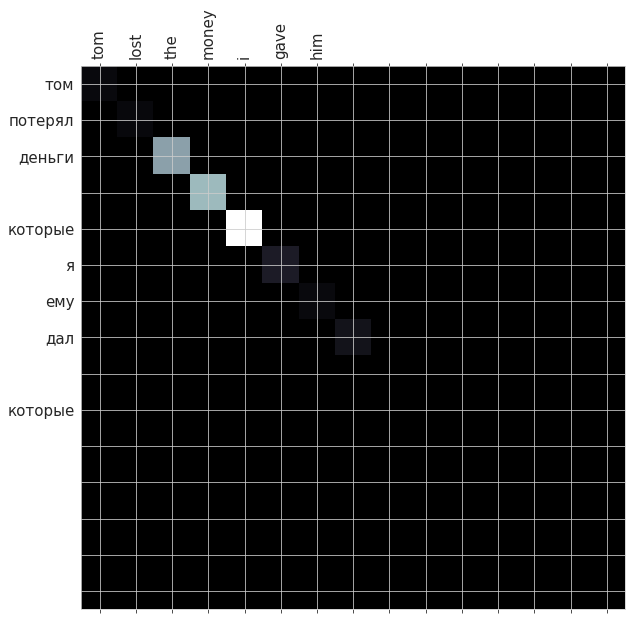

In [ ]:
#40 epochs hidden 512
evaluateAndShowAttention(random.choice(train_pairs), model=model)

Lets create model for old Slavinic - Russian corpus

In [22]:
config = {  
    'path'  :'./old_slav.txt', #old slavenic - rus
    #'path':'./rus.txt', #rus-eng
    'MAX_LENGTH':82,
    'reverse':True,
    'pad_index':[0,1],
    
    'batch_size':8, # for short datasets use batch_size - 8, for big dataset - 256

    'teacher_forcing_ratio': 0.5,
    'hidden_size':768,
    'num_epochs':100,
    
    'lr': 0.001
}

In [26]:
#old slavinic-rus
train_pairs, tokenazer_train_src, tokenazer_train_trg, test_pairs,\
   tokenazer_test_src, tokenazer_test_trg = prepareData('eng', 'rus', config['path'], config['MAX_LENGTH'], config['reverse'])
print(random.choice(train_pairs))

Reading lines...
Read 159 sentence pairs train
Read 69 sentence pairs test
Trimmed to 159 sentence train pairs
Trimmed to 69 sentence test pairs
Counting words...


100%|██████████| 69/69 [00:00<00:00, 557624.23it/s]

['повелѣ к себѣ призвати нѣкоего кузнеца от стран царства тесалискаго', 'повелел призвать к себе некоего кузнеца выходца из страны фессалии']


In [27]:
training_pairs = [tensorsFromPair(train_pair, tokenazer_train_src, tokenazer_train_trg, MAX_LENGTH=config['MAX_LENGTH'])
                      for train_pair in tqdm(train_pairs)]
testing_pairs = [tensorsFromPair(test_pair, tokenazer_test_src, tokenazer_test_trg, MAX_LENGTH=config['MAX_LENGTH'])
                      for test_pair in tqdm(test_pairs)]
train_loader = torch.utils.data.DataLoader(training_pairs, batch_size=config['batch_size'], shuffle=True)
test_loader = torch.utils.data.DataLoader(testing_pairs, batch_size=config['batch_size'], shuffle=False)

100%|██████████| 69/69 [00:00<00:00, 9999.20it/s]


train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.30it/s]

epochs:   1%|          | 1/100 [00:05<08:47,  5.33s/it]

Epoch train loss 5.077933001518249
Epoch val_loss 5.016286373138428



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.56it/s]

epochs:   2%|▏         | 2/100 [00:10<08:25,  5.16s/it]

Epoch train loss 4.47817096710205
Epoch val_loss 4.513311862945557



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.56it/s]

epochs:   3%|▎         | 3/100 [00:15<08:16,  5.12s/it]

Epoch train loss 3.9848037123680116
Epoch val_loss 4.101437568664551



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.54it/s]

epochs:   4%|▍         | 4/100 [00:20<08:10,  5.11s/it]

Epoch train loss 3.627034032344818
Epoch val_loss 3.4361472129821777



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.55it/s]

epochs:   5%|▌         | 5/100 [00:25<08:02,  5.08s/it]

Epoch train loss 3.4862202167510987
Epoch val_loss 3.3881897926330566



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.55it/s]

epochs:   6%|▌         | 6/100 [00:30<07:57,  5.08s/it]

Epoch train loss 3.364086639881134
Epoch val_loss 3.2121472358703613



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.55it/s]

epochs:   7%|▋         | 7/100 [00:35<07:54,  5.10s/it]

Epoch train loss 3.3000328660011293
Epoch val_loss 3.028501510620117



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.54it/s]

epochs:   8%|▊         | 8/100 [00:40<07:46,  5.07s/it]

Epoch train loss 3.290800416469574
Epoch val_loss 3.598494529724121



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.54it/s]

epochs:   9%|▉         | 9/100 [00:45<07:38,  5.04s/it]

Epoch train loss 3.225978934764862
Epoch val_loss 2.7961459159851074



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.48it/s]

epochs:  10%|█         | 10/100 [00:50<07:34,  5.05s/it]

Epoch train loss 3.1995778322219848
Epoch val_loss 3.281172513961792



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.59it/s]

epochs:  11%|█         | 11/100 [00:55<07:31,  5.07s/it]

Epoch train loss 3.147300624847412
Epoch val_loss 3.1676671504974365



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.58it/s]

epochs:  12%|█▏        | 12/100 [01:00<07:20,  5.00s/it]

Epoch train loss 3.1039059281349184
Epoch val_loss 3.7149498462677



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.58it/s]

epochs:  13%|█▎        | 13/100 [01:05<07:13,  4.98s/it]

Epoch train loss 3.0813185572624207
Epoch val_loss 3.212834358215332



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.56it/s]

epochs:  14%|█▍        | 14/100 [01:10<07:05,  4.95s/it]

Epoch train loss 3.0401174306869505
Epoch val_loss 3.3641140460968018



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.56it/s]

epochs:  15%|█▌        | 15/100 [01:15<07:03,  4.99s/it]

Epoch train loss 3.0521572113037108
Epoch val_loss 3.259162187576294



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.44it/s]

epochs:  16%|█▌        | 16/100 [01:20<07:04,  5.06s/it]

Epoch train loss 3.0072965145111086
Epoch val_loss 3.1423346996307373



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.50it/s]

epochs:  17%|█▋        | 17/100 [01:25<06:59,  5.06s/it]

Epoch train loss 2.973143494129181
Epoch val_loss 2.904334545135498



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.55it/s]

epochs:  18%|█▊        | 18/100 [01:30<06:53,  5.04s/it]

Epoch train loss 2.9616747975349424
Epoch val_loss 2.9610249996185303



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.54it/s]

validation sample batches: 100%|██████████| 9/9 [00:00<00:00, 18.23it/s]


Epoch train loss 2.870888125896454
Epoch val_loss 2.851915121078491


train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.52it/s]

epochs:  20%|██        | 20/100 [01:41<06:46,  5.09s/it]

Epoch train loss 2.894040107727051
Epoch val_loss 3.131866216659546



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.51it/s]

epochs:  21%|██        | 21/100 [01:46<06:42,  5.09s/it]

Epoch train loss 2.884211015701294
Epoch val_loss 3.017305612564087



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.49it/s]

epochs:  22%|██▏       | 22/100 [01:51<06:36,  5.08s/it]

Epoch train loss 2.8671384692192077
Epoch val_loss 3.161123752593994



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.52it/s]

epochs:  23%|██▎       | 23/100 [01:56<06:29,  5.05s/it]

Epoch train loss 2.8358040332794188
Epoch val_loss 2.9728593826293945



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.56it/s]

epochs:  24%|██▍       | 24/100 [02:01<06:23,  5.05s/it]

Epoch train loss 2.805192732810974
Epoch val_loss 2.7909984588623047



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s]

epochs:  25%|██▌       | 25/100 [02:06<06:21,  5.08s/it]

Epoch train loss 2.778447997570038
Epoch val_loss 3.3726577758789062



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.52it/s]

epochs:  26%|██▌       | 26/100 [02:11<06:17,  5.11s/it]

Epoch train loss 2.7802723050117493
Epoch val_loss 2.2666258811950684



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.49it/s]

epochs:  27%|██▋       | 27/100 [02:16<06:11,  5.09s/it]

Epoch train loss 2.716319960355759
Epoch val_loss 2.8844540119171143



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.44it/s]

epochs:  28%|██▊       | 28/100 [02:22<06:09,  5.13s/it]

Epoch train loss 2.735615634918213
Epoch val_loss 2.668565034866333



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.46it/s]

epochs:  29%|██▉       | 29/100 [02:27<06:03,  5.11s/it]

Epoch train loss 2.6845681607723235
Epoch val_loss 3.045680284500122



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.45it/s]

epochs:  30%|███       | 30/100 [02:32<05:58,  5.12s/it]

Epoch train loss 2.657450258731842
Epoch val_loss 3.1929171085357666



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.48it/s]

epochs:  31%|███       | 31/100 [02:37<05:52,  5.11s/it]

Epoch train loss 2.6221509516239165
Epoch val_loss 3.1045925617218018



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s]

epochs:  32%|███▏      | 32/100 [02:42<05:46,  5.09s/it]

Epoch train loss 2.6351100862026215
Epoch val_loss 2.762148857116699



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.49it/s]

epochs:  33%|███▎      | 33/100 [02:47<05:40,  5.08s/it]

Epoch train loss 2.579158663749695
Epoch val_loss 2.6837806701660156



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.45it/s]

epochs:  34%|███▍      | 34/100 [02:52<05:34,  5.08s/it]

Epoch train loss 2.5888013362884523
Epoch val_loss 2.6302566528320312



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.36it/s]

epochs:  35%|███▌      | 35/100 [02:57<05:32,  5.11s/it]

Epoch train loss 2.551533114910126
Epoch val_loss 2.7885966300964355



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.49it/s]

epochs:  36%|███▌      | 36/100 [03:02<05:27,  5.11s/it]

Epoch train loss 2.557392048835754
Epoch val_loss 2.3065505027770996



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.49it/s]

epochs:  37%|███▋      | 37/100 [03:07<05:23,  5.13s/it]

Epoch train loss 2.488406938314438
Epoch val_loss 2.6050326824188232



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.48it/s]

epochs:  38%|███▊      | 38/100 [03:13<05:19,  5.15s/it]

Epoch train loss 2.460621067881584
Epoch val_loss 2.685091733932495



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.48it/s]

epochs:  39%|███▉      | 39/100 [03:18<05:11,  5.11s/it]

Epoch train loss 2.492963945865631
Epoch val_loss 2.2007718086242676



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.48it/s]

epochs:  40%|████      | 40/100 [03:23<05:07,  5.13s/it]

Epoch train loss 2.467246860265732
Epoch val_loss 2.055887222290039



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.42it/s]

epochs:  41%|████      | 41/100 [03:28<05:04,  5.15s/it]

Epoch train loss 2.3954300969839095
Epoch val_loss 3.0943408012390137



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.45it/s]

epochs:  42%|████▏     | 42/100 [03:33<04:57,  5.14s/it]

Epoch train loss 2.3631215363740923
Epoch val_loss 3.018193006515503



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.44it/s]

epochs:  43%|████▎     | 43/100 [03:38<04:53,  5.15s/it]

Epoch train loss 2.398254579305649
Epoch val_loss 2.795976400375366



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s]

epochs:  44%|████▍     | 44/100 [03:44<04:48,  5.16s/it]

Epoch train loss 2.364123284816742
Epoch val_loss 3.0807361602783203



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.42it/s]

epochs:  45%|████▌     | 45/100 [03:49<04:42,  5.15s/it]

Epoch train loss 2.376800465583801
Epoch val_loss 1.5305413007736206



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s]

epochs:  46%|████▌     | 46/100 [03:54<04:38,  5.15s/it]

Epoch train loss 2.378835695981979
Epoch val_loss 2.0199670791625977



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.40it/s]

epochs:  47%|████▋     | 47/100 [03:59<04:33,  5.17s/it]

Epoch train loss 2.3859127163887024
Epoch val_loss 2.6611711978912354



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.44it/s]

epochs:  48%|████▊     | 48/100 [04:04<04:29,  5.18s/it]

Epoch train loss 2.284013420343399
Epoch val_loss 2.091870069503784



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.42it/s]

epochs:  49%|████▉     | 49/100 [04:10<04:25,  5.21s/it]

Epoch train loss 2.3166925817728043
Epoch val_loss 3.0598158836364746



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.45it/s]

epochs:  50%|█████     | 50/100 [04:15<04:19,  5.18s/it]

Epoch train loss 2.3094814002513884
Epoch val_loss 1.8238468170166016



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.51it/s]

epochs:  51%|█████     | 51/100 [04:20<04:12,  5.14s/it]

Epoch train loss 2.3066692024469377
Epoch val_loss 2.854551315307617



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.46it/s]

epochs:  52%|█████▏    | 52/100 [04:25<04:06,  5.14s/it]

Epoch train loss 2.3269545674324035
Epoch val_loss 2.6797354221343994



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.37it/s]

epochs:  53%|█████▎    | 53/100 [04:30<04:01,  5.14s/it]

Epoch train loss 2.2668091535568236
Epoch val_loss 3.112346887588501



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.48it/s]

epochs:  54%|█████▍    | 54/100 [04:35<03:55,  5.12s/it]

Epoch train loss 2.2436124205589296
Epoch val_loss 2.975494146347046



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s]

epochs:  55%|█████▌    | 55/100 [04:40<03:50,  5.13s/it]

Epoch train loss 2.304187738895416
Epoch val_loss 1.1845589876174927



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s]

epochs:  56%|█████▌    | 56/100 [04:45<03:45,  5.14s/it]

Epoch train loss 2.2530337631702424
Epoch val_loss 2.228036880493164



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.39it/s]

validation sample batches: 100%|██████████| 9/9 [00:00<00:00, 21.19it/s]


Epoch train loss 2.252680081129074
Epoch val_loss 2.6942269802093506


train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s]

epochs:  58%|█████▊    | 58/100 [04:56<03:36,  5.16s/it]

Epoch train loss 2.2496008813381194
Epoch val_loss 1.759424090385437



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.44it/s]

epochs:  59%|█████▉    | 59/100 [05:01<03:31,  5.17s/it]

Epoch train loss 2.229118651151657
Epoch val_loss 2.10280179977417



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s]

epochs:  60%|██████    | 60/100 [05:06<03:26,  5.17s/it]

Epoch train loss 2.242647594213486
Epoch val_loss 1.1442395448684692



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.35it/s]

epochs:  61%|██████    | 61/100 [05:11<03:21,  5.17s/it]

Epoch train loss 2.2338708639144897
Epoch val_loss 1.5918705463409424



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.40it/s]

epochs:  62%|██████▏   | 62/100 [05:17<03:18,  5.22s/it]

Epoch train loss 2.2451168596744537
Epoch val_loss 2.808472156524658



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s]

epochs:  63%|██████▎   | 63/100 [05:22<03:12,  5.19s/it]

Epoch train loss 2.2388547986745833
Epoch val_loss 2.243694305419922



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.44it/s]

epochs:  64%|██████▍   | 64/100 [05:27<03:06,  5.17s/it]

Epoch train loss 2.2231377452611922
Epoch val_loss 2.6386232376098633



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.39it/s]

epochs:  65%|██████▌   | 65/100 [05:32<03:00,  5.15s/it]

Epoch train loss 2.2491820394992827
Epoch val_loss 2.3977508544921875



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s]

epochs:  66%|██████▌   | 66/100 [05:37<02:54,  5.15s/it]

Epoch train loss 2.2482460856437685
Epoch val_loss 2.4853222370147705



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.45it/s]

epochs:  67%|██████▋   | 67/100 [05:42<02:50,  5.16s/it]

Epoch train loss 2.2913754284381866
Epoch val_loss 2.6489198207855225



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.40it/s]

epochs:  68%|██████▊   | 68/100 [05:48<02:46,  5.21s/it]

Epoch train loss 2.205251532793045
Epoch val_loss 2.109649896621704



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.44it/s]

epochs:  69%|██████▉   | 69/100 [05:53<02:42,  5.23s/it]

Epoch train loss 2.226356452703476
Epoch val_loss 1.7868907451629639



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.42it/s]

epochs:  70%|███████   | 70/100 [05:58<02:36,  5.21s/it]

Epoch train loss 2.1464570492506025
Epoch val_loss 1.6723977327346802



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.36it/s]

epochs:  71%|███████   | 71/100 [06:03<02:32,  5.25s/it]

Epoch train loss 2.146876347064972
Epoch val_loss 2.4357123374938965



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.28it/s]

epochs:  72%|███████▏  | 72/100 [06:09<02:26,  5.24s/it]

Epoch train loss 2.1499619245529176
Epoch val_loss 1.3898413181304932



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.32it/s]

epochs:  73%|███████▎  | 73/100 [06:14<02:22,  5.27s/it]

Epoch train loss 2.159308832883835
Epoch val_loss 1.9870867729187012



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.36it/s]

epochs:  74%|███████▍  | 74/100 [06:19<02:17,  5.29s/it]

Epoch train loss 2.0604644805192946
Epoch val_loss 2.5931556224823



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.36it/s]

epochs:  75%|███████▌  | 75/100 [06:25<02:12,  5.29s/it]

Epoch train loss 2.1177601397037504
Epoch val_loss 2.863084316253662



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.32it/s]

epochs:  76%|███████▌  | 76/100 [06:30<02:07,  5.31s/it]

Epoch train loss 2.145990401506424
Epoch val_loss 2.481440782546997



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.30it/s]

epochs:  77%|███████▋  | 77/100 [06:35<02:02,  5.35s/it]

Epoch train loss 2.0858362913131714
Epoch val_loss 1.8692514896392822



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.40it/s]

epochs:  78%|███████▊  | 78/100 [06:41<01:56,  5.30s/it]

Epoch train loss 2.0537653803825378
Epoch val_loss 1.4837182760238647



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.39it/s]

epochs:  79%|███████▉  | 79/100 [06:46<01:50,  5.28s/it]

Epoch train loss 2.102803909778595
Epoch val_loss 1.484989047050476



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.36it/s]

epochs:  80%|████████  | 80/100 [06:51<01:46,  5.31s/it]

Epoch train loss 2.115046274662018
Epoch val_loss 1.7750204801559448



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.39it/s]

epochs:  81%|████████  | 81/100 [06:56<01:40,  5.28s/it]

Epoch train loss 2.1155096530914306
Epoch val_loss 1.428308129310608



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.37it/s]

epochs:  82%|████████▏ | 82/100 [07:02<01:35,  5.30s/it]

Epoch train loss 2.1097780883312227
Epoch val_loss 2.363940715789795



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.34it/s]

epochs:  83%|████████▎ | 83/100 [07:07<01:29,  5.29s/it]

Epoch train loss 2.0895856082439423
Epoch val_loss 2.7126286029815674



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s]

epochs:  84%|████████▍ | 84/100 [07:12<01:24,  5.27s/it]

Epoch train loss 2.083921781182289
Epoch val_loss 1.396645188331604



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.39it/s]

epochs:  85%|████████▌ | 85/100 [07:18<01:19,  5.29s/it]

Epoch train loss 2.1837888240814207
Epoch val_loss 2.6109018325805664



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.39it/s]

epochs:  86%|████████▌ | 86/100 [07:23<01:14,  5.29s/it]

Epoch train loss 2.1863447308540342
Epoch val_loss 2.7012062072753906



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.36it/s]

epochs:  87%|████████▋ | 87/100 [07:28<01:08,  5.27s/it]

Epoch train loss 2.154748851060867
Epoch val_loss 2.824141263961792



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.36it/s]

epochs:  88%|████████▊ | 88/100 [07:33<01:03,  5.29s/it]

Epoch train loss 2.1836895823478697
Epoch val_loss 2.4046225547790527



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.36it/s]

epochs:  89%|████████▉ | 89/100 [07:39<00:58,  5.29s/it]

Epoch train loss 2.101610839366913
Epoch val_loss 1.8595833778381348



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.42it/s]

epochs:  90%|█████████ | 90/100 [07:44<00:52,  5.25s/it]

Epoch train loss 2.0623261511325834
Epoch val_loss 1.4620699882507324



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.34it/s]

epochs:  91%|█████████ | 91/100 [07:49<00:47,  5.24s/it]

Epoch train loss 2.055152291059494
Epoch val_loss 3.0238587856292725



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.40it/s]

epochs:  92%|█████████▏| 92/100 [07:54<00:41,  5.24s/it]

Epoch train loss 2.1152262657880785
Epoch val_loss 2.2403385639190674



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.38it/s]

epochs:  93%|█████████▎| 93/100 [08:00<00:36,  5.23s/it]

Epoch train loss 2.0943737506866453
Epoch val_loss 2.2785491943359375



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.36it/s]

epochs:  94%|█████████▍| 94/100 [08:05<00:31,  5.22s/it]

Epoch train loss 2.0652782917022705
Epoch val_loss 2.372061014175415



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.37it/s]

epochs:  95%|█████████▌| 95/100 [08:10<00:26,  5.22s/it]

Epoch train loss 2.068182948231697
Epoch val_loss 2.558293581008911



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.36it/s]

epochs:  96%|█████████▌| 96/100 [08:15<00:20,  5.23s/it]

Epoch train loss 2.1201832592487335
Epoch val_loss 1.5564111471176147



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.34it/s]

epochs:  97%|█████████▋| 97/100 [08:21<00:15,  5.30s/it]

Epoch train loss 2.1080902814865112
Epoch val_loss 2.7174205780029297



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.39it/s]

epochs:  98%|█████████▊| 98/100 [08:26<00:10,  5.29s/it]

Epoch train loss 2.033291169255972
Epoch val_loss 3.0570099353790283



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.38it/s]

epochs:  99%|█████████▉| 99/100 [08:31<00:05,  5.27s/it]

Epoch train loss 2.1576453864574434
Epoch val_loss 1.5053932666778564



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s]

validation sample batches: 100%|██████████| 9/9 [00:00<00:00, 16.53it/s]


Epoch train loss 2.1142960727214812
Epoch val_loss 2.230419635772705


epochs: 100%|██████████| 100/100 [08:37<00:00,  5.17s/it]


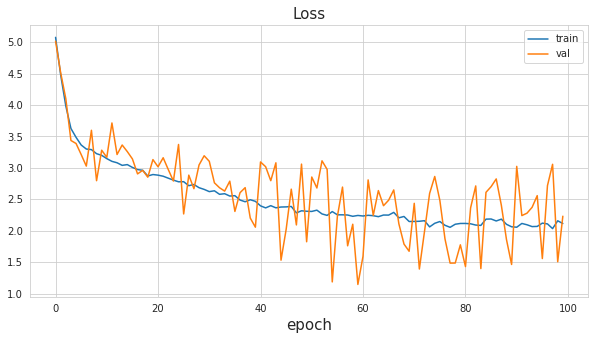

In [30]:
#model with batches old slav-rus

encoder1 = EncoderRNN(200, config['hidden_size'])
attn_decoder1 = AttnDecoderRNN(config['hidden_size'], 200, config['MAX_LENGTH'], dropout_p=0.1)
model=TONModel(encoder1, attn_decoder1, config['teacher_forcing_ratio']).to(device)

optimizer = optim.Adam(model.parameters(), lr=config['lr'])
criterion = nn.NLLLoss(ignore_index=0)

train_modelIters(model, optimizer, train_loader, test_loader, criterion, config['num_epochs'])

In [31]:
#40 epochs hidden 512 BPE
evaluateRandomly(model, train_pairs, tokenazer_train_src, tokenazer_train_trg)

> падеть не имыи подпора словесъ книжныхъ и мyдростеи къниги
= то он падет не имея опоры в словах книжных и в мудрости книжнои
< то он падет не имея опоры в слониж кж кж кж кж кж кж кж кж кж кж кж кж кж кж кж кж кж кж кж кж кж кж кж кж кж кж кж кж кж кж кж к

Blue score of this sentence  -  2.462550292045679e-06

Blue score of this sentence my function -  0.8079268292682926

> i посадиша его на столѣ
= и посадили его на княжескии престол
< и посадили его на княжестои престои престои престои престои престои престои престои престои престои престои престои престои престои престои

Blue score of this sentence  -  9.639696470400881e-12

Blue score of this sentence my function -  0.7957317073170731

> и въ ӡълое времѧ нихто емy не поможетъ
= и в лихое время никто ему не поможет
< и вре еет не вре не поет в вкмумо в нек по в

Blue score of this sentence  -  0.000366948409740609

Blue score of this sentence my function -  0.43452380952380953

> волокитою оуморитъ
= томит волокитои
< томит воло

In [32]:
#40 epochs hidden 512 BPE
evaluateRandomly(model, test_pairs, tokenazer_test_src, tokenazer_test_trg)

> или ӡемлю переоралъ
= или землю перепахал
< эторэторэторэторэторэторэторэторэторэторэторэторэторэторэторэторэторэторэторэторэторэторэторэторэторэторэторэторэторэторэторэторэторэторэторэторэторэторэторэторэтор

Blue score of this sentence  -  0

Blue score of this sentence my function -  0.0

> ѥще же гнѣвъмь одьржима соущи
= но все еще будучи одержима гневом
< о о о о о оиязы о ои о о о ос о о о

Blue score of this sentence  -  0

Blue score of this sentence my function -  0.0

> да аще бо погибнеть единъ ею
= и если погибнет один из них
< на злалалалалалалалалалалалалалалалалалалалалалалалалалалалалалалалалалалалалалалалалалалалалалалалалалалалалалалалалалалалалалалалалалалалалалалалалалалалалалалала

Blue score of this sentence  -  0

Blue score of this sentence my function -  0.0

> прииде же и богатьства иӡъобилование въ съкровища ихъ
= пришло изобилие богатств в их сокровищницах
< человеен этоен этоен этоен этоен этоен этоен этоен этоен этоен этоен этоен этоен этоен этоен этоен 

input = плѣненыя же дyшею оплѣнити къ благочестию
output = плененных душои вернуть к благочестиючестиючестиючестиючестиючестиючестиючестиючестиючестиючестиючестиючестиючестиючестиючестиючестиючестиючестиючестиючестиюче
[3.991496392510911e-31, 1.0, 6.41989788588595e-29, 5.588263515770508e-23, 2.4443946866625765e-10, 1.347520957030633e-24, 6.4259565485273764e-27, 6.4259565485273764e-27, 6.4259565485273764e-27, 6.4259565485273764e-27, 6.4259565485273764e-27, 6.4259565485273764e-27, 6.4259565485273764e-27, 6.4259565485273764e-27, 6.4259565485273764e-27, 6.4259565485273764e-27, 6.4259565485273764e-27, 6.4259565485273764e-27, 6.4259565485273764e-27, 6.4259565485273764e-27, 6.4259565485273764e-27, 6.4259565485273764e-27]


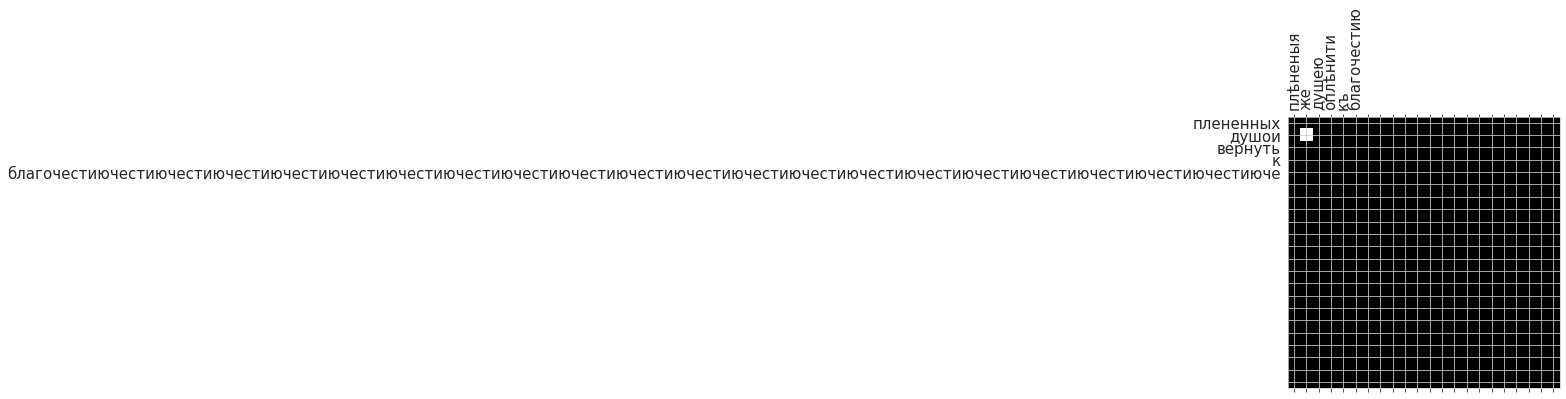

In [49]:
#40 epochs hidden 512
evaluateAndShowAttention(random.choice(train_pairs), model=model)